##### Machine Learning Nanodegree
##### Capstone Project: Electric Vehicle Detection 
##### Salvador Nunez

# Setup

In [1]:
# Import libraries necessary for this project
import os.path
import time
import pickle

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Image 

from sklearn.externals import joblib
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, confusion_matrix, make_scorer
from sklearn.model_selection import GridSearchCV, ShuffleSplit

# Import functions defined for this project, located in this repo in ev_capstone_lib.py
import ev_capstone_lib as ev

# Pretty display for notebooks
%matplotlib inline

In [2]:
# set visualization defaults
title_font = {'fontname':'Arial', 'size':'18', 'color':'black', 
              'weight':'bold','verticalalignment':'bottom'} 
axis_font = {'fontname':'Arial', 'size':'16','weight':'bold'}

# Data Exploration

## Import

In [3]:
ev_train_raw = pd.read_csv('source_files/EV_train.csv')
ev_train_labels_raw = pd.read_csv('source_files/EV_train_labels.csv')

## Inspect

In [4]:
print(ev_train_raw.shape)
print(ev_train_labels_raw.shape)

(1590, 2881)
(1590, 2881)


In [5]:
display(ev_train_raw.head())
display(ev_train_labels_raw.head())

,House ID,Interval_1,Interval_2,Interval_3,Interval_4,Interval_5,Interval_6,Interval_7,Interval_8,Interval_9,...,Interval_2871,Interval_2872,Interval_2873,Interval_2874,Interval_2875,Interval_2876,Interval_2877,Interval_2878,Interval_2879,Interval_2880
0,11655099,0.950,0.826,0.361,0.238,0.342,0.233000,0.351000,0.194000,0.292000,...,0.664,0.783,0.601,0.639,0.417,0.439,0.226,0.190,0.710,0.728
1,11633257,0.353,0.327,0.358,0.292,0.285,0.304000,0.361000,0.342000,0.355000,...,0.536,0.558,0.622,0.634,0.513,0.421,0.273,0.296,0.291,0.289
2,11651552,0.150,0.181,0.150,0.150,0.131,0.125000,0.088000,0.106000,0.094000,...,2.125,0.881,0.481,1.194,0.138,0.119,0.038,0.088,0.056,0.113
3,11636092,2.088,2.075,2.121,2.098,2.046,2.081000,1.847000,0.420000,0.399000,...,0.620,0.487,0.563,0.419,0.379,0.359,0.347,0.325,0.330,0.340
4,11647239,1.416,1.250,1.270,1.258,1.239,1.753105,4.609256,4.619256,4.075151,...,1.596,1.667,1.569,1.664,1.580,1.635,1.568,1.565,1.575,1.571


,House ID,Interval_1,Interval_2,Interval_3,Interval_4,Interval_5,Interval_6,Interval_7,Interval_8,Interval_9,...,Interval_2871,Interval_2872,Interval_2873,Interval_2874,Interval_2875,Interval_2876,Interval_2877,Interval_2878,Interval_2879,Interval_2880
0,11655099,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,11633257,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,11651552,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,11636092,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,11647239,0,0,0,0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


## Quantify Class Imbalance

In [6]:
# % EV Houses
ev_houses_raw = sum(ev_train_labels_raw.drop('House ID', axis=1).sum(axis=1) > 0)
print("{} houses have EVs, representing {:.0%} of all houses.".format(
    ev_houses_raw, ev_houses_raw/ev_train_labels_raw.shape[0]
))

485 houses have EVs, representing 31% of all houses.


In [7]:
# % EV Intervals Total
ev_intervals_raw = ev_train_labels_raw.drop('House ID', axis=1).values.sum()
print("{} intervals have charging EVs, representing {:.0%} of all intervals for all houses.".format(
    ev_intervals_raw, ev_intervals_raw/(1590*2800)
))

106910 intervals have charging EVs, representing 2% of all intervals for all houses.


In [8]:
print("{} intervals have charging EVs, representing {:.0%} of all intervals for all EV houses.".format(
    ev_intervals_raw, ev_intervals_raw/(485*2800)
))

106910 intervals have charging EVs, representing 8% of all intervals for all EV houses.


## Quantify Missing Values

In [9]:
print(ev_train_raw.isnull().values.any())  # Null values in training dataset?
print(ev_train_labels_raw.isnull().values.any())  #Null values in training labels?

True
False


In [10]:
# Count Nulls
ev_train_raw.isnull().sum().sum()

720

In [11]:
# Count Nulls by House
print(ev_train_raw['House ID'][ev_train_raw.isnull().sum(axis=1)>0])
print(ev_train_raw.isnull().sum(axis=1)[ev_train_raw.isnull().sum(axis=1)>0])

290     11637447
539     11635802
1159    11637232
1374    11632700
Name: House ID, dtype: int64
290      96
539      48
1159    432
1374    144
dtype: int64


In [12]:
# Show records with missing values
ev_train_raw[ev_train_raw.isnull().any(axis=1)]

,House ID,Interval_1,Interval_2,Interval_3,Interval_4,Interval_5,Interval_6,Interval_7,Interval_8,Interval_9,...,Interval_2871,Interval_2872,Interval_2873,Interval_2874,Interval_2875,Interval_2876,Interval_2877,Interval_2878,Interval_2879,Interval_2880
290,11637447,2.395,2.380,2.336,2.417,2.422,2.497,2.486,3.015,2.317,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
539,11635802,0.249,0.271,0.266,0.255,0.247,0.280,0.178,0.237,0.133,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1159,11637232,1.218,1.087,0.995,0.791,0.798,0.756,0.745,0.736,0.699,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1374,11632700,0.113,0.106,0.113,0.150,0.119,0.106,0.100,0.144,0.144,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Exploratory Visualizations

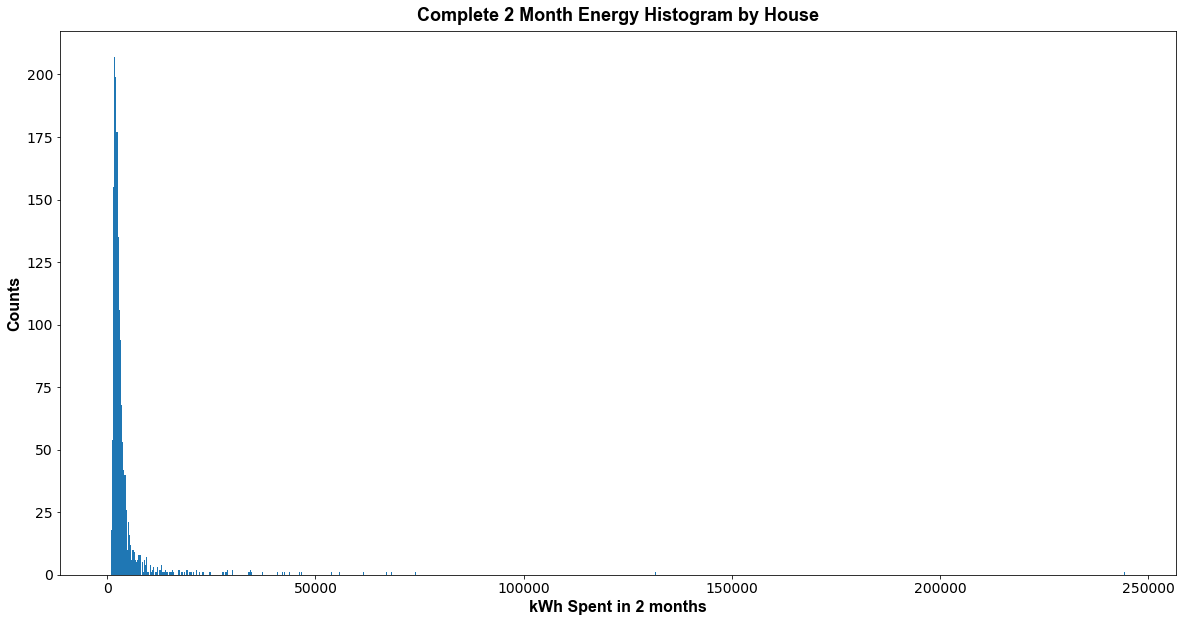

In [13]:
house_totals = ev_train_raw.drop(['House ID'], axis=1).sum(axis=1)
plt.figure(figsize=(20,10))
plt.hist(house_totals, bins='auto') 
plt.xlabel('kWh Spent in 2 months', **axis_font)
plt.ylabel('Counts', **axis_font)
plt.title("Complete 2 Month Energy Histogram by House", **title_font)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.show()

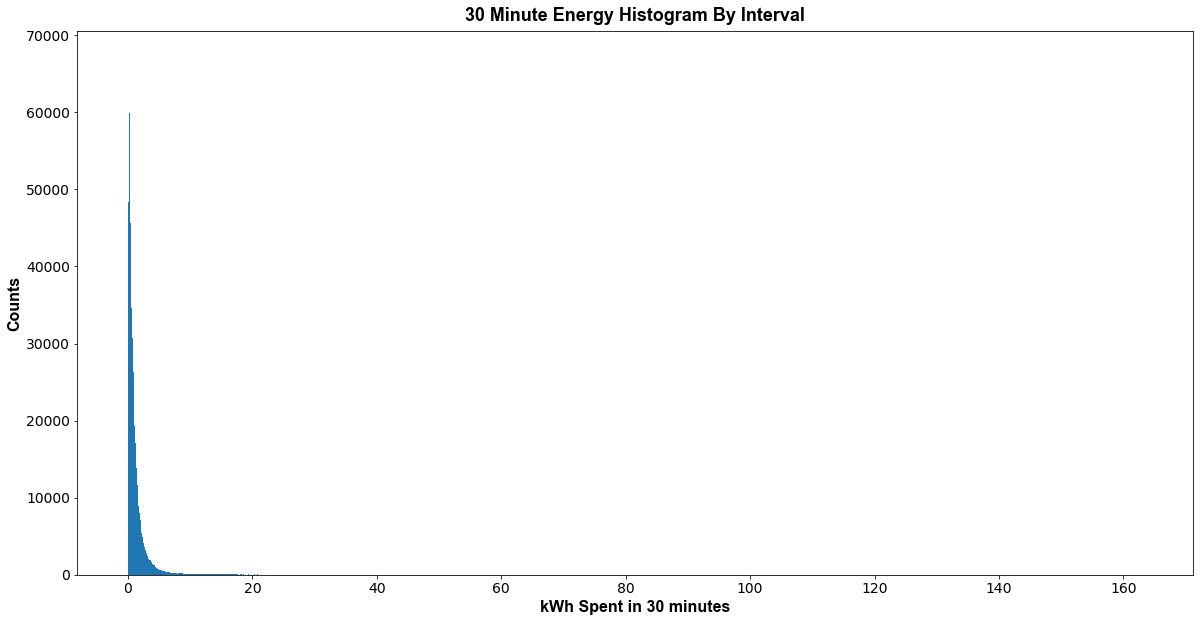

In [14]:
interval_values = ev_train_raw.drop(['House ID'], axis=1).values.flatten()
interval_values = interval_values[~np.isnan(interval_values)]
plt.figure(figsize=(20,10))
plt.hist(interval_values, bins='auto') 
plt.xlabel('kWh Spent in 30 minutes', **axis_font)
plt.ylabel('Counts', **axis_font)
plt.title("30 Minute Energy Histogram By Interval", **title_font)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.show()

# Data Preprocessing

## Pivot and Combine

In [15]:
ev_train_kwh_pivot = ev.pivot_raw_df(ev_train_raw, 'kWh')
display(ev_train_kwh_pivot.head())

,House ID,Interval,kWh
0,11628280,1,1.114
1,11628280,2,0.845
2,11628280,3,0.463
3,11628280,4,0.453
4,11628280,5,0.610


In [16]:
ev_train_labels_pivot = ev.pivot_raw_df(ev_train_labels_raw, 'Label')
display(ev_train_labels_pivot.head())

,House ID,Interval,Label
0,11628280,1,0
1,11628280,2,0
2,11628280,3,0
3,11628280,4,0
4,11628280,5,0


In [17]:
ev_train_piv_w_lab = pd.concat([ev_train_kwh_pivot, ev_train_labels_pivot['Label']], axis=1)
display(ev_train_piv_w_lab.head())

,House ID,Interval,kWh,Label
0,11628280,1,1.114,0
1,11628280,2,0.845,0
2,11628280,3,0.463,0
3,11628280,4,0.453,0
4,11628280,5,0.610,0


## Add Temporal Dimensions

In [18]:
ev_train_piv_lab_tmp = ev.add_temp_dim(ev_train_piv_w_lab)
display(ev_train_piv_lab_tmp.head())

,House ID,Day,Hour,Half Hour,Interval,kWh,Label
0,11628280,1,1,1,1,1.114,0
1,11628280,1,1,2,2,0.845,0
2,11628280,1,2,3,3,0.463,0
3,11628280,1,2,4,4,0.453,0
4,11628280,1,3,5,5,0.610,0


## Fill in Missing Values

In [19]:
ev_train_piv_lab_tmp_filled = ev.fill_with_mean(ev_train_piv_lab_tmp)
display(ev_train_piv_lab_tmp_filled.head())

/Users/salvadornunez/Personal/udacity-mlnd-ev-capstone/ev_capstone_lib.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_filled['kWh'][house_rf&interval_rf] = house_half_hour_average


,House ID,Day,Hour,Half Hour,Interval,kWh,Label
0,11628280,1,1,1,1,1.114,0
1,11628280,1,1,2,2,0.845,0
2,11628280,1,2,3,3,0.463,0
3,11628280,1,2,4,4,0.453,0
4,11628280,1,3,5,5,0.610,0


# House Classification

## Training and Validation Split

In [20]:
X_house, y_house = ev.house_agg_and_split(ev_train_piv_lab_tmp_filled)

In [21]:
X_house.columns.values

array(['House ID', 'u_1', 'u_2', 'u_3', 'u_4', 'u_5', 'u_6', 'u_7', 'u_8',
       'u_9', 'u_10', 'u_11', 'u_12', 'u_13', 'u_14', 'u_15', 'u_16',
       'u_17', 'u_18', 'u_19', 'u_20', 'u_21', 'u_22', 'u_23', 'u_24',
       'u_25', 'u_26', 'u_27', 'u_28', 'u_29', 'u_30', 'u_31', 'u_32',
       'u_33', 'u_34', 'u_35', 'u_36', 'u_37', 'u_38', 'u_39', 'u_40',
       'u_41', 'u_42', 'u_43', 'u_44', 'u_45', 'u_46', 'u_47', 'u_48',
       's_1', 's_2', 's_3', 's_4', 's_5', 's_6', 's_7', 's_8', 's_9',
       's_10', 's_11', 's_12', 's_13', 's_14', 's_15', 's_16', 's_17',
       's_18', 's_19', 's_20', 's_21', 's_22', 's_23', 's_24', 's_25',
       's_26', 's_27', 's_28', 's_29', 's_30', 's_31', 's_32', 's_33',
       's_34', 's_35', 's_36', 's_37', 's_38', 's_39', 's_40', 's_41',
       's_42', 's_43', 's_44', 's_45', 's_46', 's_47', 's_48', 'p_1',
       'p_2', 'p_3', 'p_4', 'p_5', 'p_6', 'p_7', 'p_8', 'p_9', 'p_10',
       'p_11', 'p_12', 'p_13', 'p_14', 'p_15', 'p_16', 'p_17', 'p_18',
     

In [22]:
display(X_house.head())
display(y_house.head())

,House ID,u_1,u_2,u_3,u_4,u_5,u_6,u_7,u_8,u_9,...,p_39,p_40,p_41,p_42,p_43,p_44,p_45,p_46,p_47,p_48
0,11628280,1.034950,0.990733,0.904383,0.940583,0.958350,0.940750,0.936317,0.919983,0.894133,...,0.021406,0.020981,0.019509,0.019009,0.019226,0.018909,0.019017,0.019521,0.019504,0.019241
1,11628291,0.742283,0.743917,0.742250,0.740300,0.743651,0.838403,0.771068,0.797265,0.762628,...,0.020703,0.018956,0.018786,0.018658,0.017564,0.017195,0.017451,0.018865,0.018214,0.017874
2,11628301,0.236132,0.273704,0.255804,0.248360,0.191183,0.202845,0.314648,0.314576,0.251421,...,0.063615,0.060917,0.055962,0.040179,0.025159,0.013686,0.010051,0.006760,0.006476,0.005591
3,11628319,0.779583,0.766733,0.660650,0.591733,0.600967,0.578200,0.581083,0.595033,0.615067,...,0.030123,0.035465,0.036182,0.035222,0.032022,0.030527,0.027833,0.024870,0.019554,0.017096
4,11628335,0.299017,0.301467,0.297050,0.286950,0.283717,0.293583,0.790850,0.914083,0.929167,...,0.037180,0.037238,0.021009,0.016897,0.015468,0.012938,0.011480,0.009744,0.008606,0.008468


0    0
1    1
2    1
3    0
4    0
Name: House Label, dtype: int64

In [23]:
# inspect for patterns at the house level
house_id_label = pd.concat([X_house['House ID'], y_house], axis=1)
display(house_id_label.head())

,House ID,House Label
0,11628280,0
1,11628291,1
2,11628301,1
3,11628319,0
4,11628335,0


In [24]:
house_id_label.groupby(['House Label']).agg(['mean','count'])

House ID      
                     mean count
House Label                    
0            1.164213e+07  1105
1            1.164117e+07   485

In [25]:
house_id_label.corr()

,House ID,House Label
House ID,1.000000,-0.055086
House Label,-0.055086,1.000000


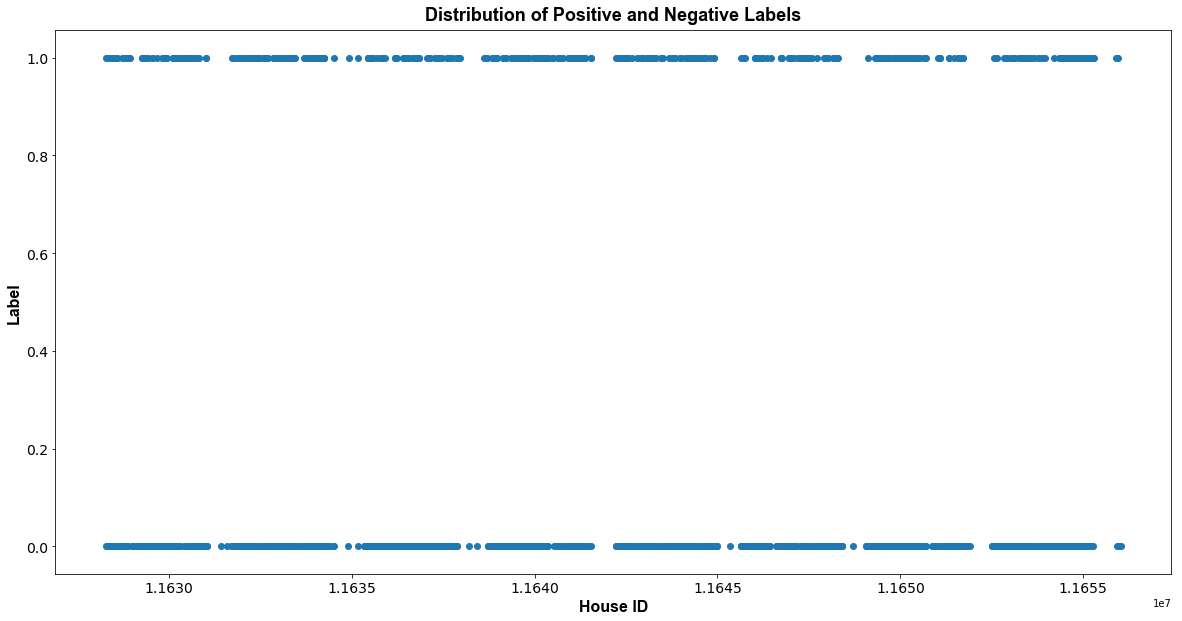

In [26]:
plt.figure(figsize=(20,10))
plt.scatter(x=house_id_label['House ID'], y=house_id_label['House Label']) 
plt.xlabel('House ID', **axis_font)
plt.ylabel('Label', **axis_font)
plt.title("Distribution of Positive and Negative Labels", **title_font)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.show()

In [27]:
X_train_house, X_valid_house, y_train_house, y_valid_house = train_test_split(X_house,
                                                                            y_house,
                                                                            test_size=0.25,
                                                                            random_state=42)

## Augment Data

## Perform K-Means Clustering

In [28]:
Image(url= "http://aprs.org/Energy/Charging/L1-EV-timed-charging.GIF")

k:2, ratio:1.446, max:0.323, min:0.223.
k:3, ratio:1.509, max:0.326, min:0.216.
k:4, ratio:1.920, max:0.405, min:0.211.
k:5, ratio:2.062, max:0.465, min:0.226.
k:6, ratio:2.564, max:0.481, min:0.188.
k:7, ratio:3.322, max:0.570, min:0.171.
k:8, ratio:2.908, max:0.543, min:0.187.
k:9, ratio:5.069, max:0.614, min:0.121.
k:10, ratio:2.965, max:0.583, min:0.197.
Best clustering was when k = 9, with a ratio of 5.069


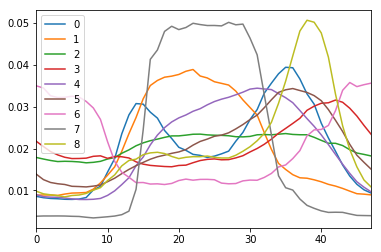

In [29]:
X_train_house, centers_df, k_col_name = ev.cluster_retrieve_best_k(X_train_house, y_train_house)

Ratio defined as the maximum percent / minimum percent, where percent is the percent of positively identified EV houses in each of the k clusters. This helps discriminate ev houses depending on what cluster it belongs to.

In [30]:
display(X_train_house.head())

,House ID,u_1,u_2,u_3,u_4,u_5,u_6,u_7,u_8,u_9,...,p_40,p_41,p_42,p_43,p_44,p_45,p_46,p_47,p_48,k_9
602,11638880,0.305867,0.289133,0.275450,0.261250,0.259183,0.291583,0.532667,0.642067,0.711217,...,0.035223,0.033186,0.030959,0.029389,0.027297,0.016718,0.012797,0.012377,0.011757,5
483,11636498,0.389817,0.371250,0.367267,0.368383,0.366217,0.365183,0.356867,0.359200,0.360800,...,0.021319,0.021060,0.021830,0.020230,0.019202,0.015799,0.013511,0.011439,0.010201,0
1286,11650343,0.237557,0.192169,0.234931,0.247390,0.181961,0.158980,0.188654,0.261955,0.222893,...,0.051914,0.053570,0.045476,0.019140,0.014406,0.011500,0.010308,0.008121,0.006240,8
1009,11645819,0.714400,0.696000,0.684533,0.673533,0.646900,0.635050,0.632483,0.598383,0.595467,...,0.023128,0.025465,0.026261,0.030501,0.032329,0.027500,0.027435,0.029378,0.029757,3
411,11635443,0.316750,0.300883,0.301883,0.294950,0.295750,0.298600,0.290733,0.284767,0.276817,...,0.053381,0.053078,0.046755,0.038444,0.024479,0.015984,0.010947,0.008577,0.007237,8


## Train Model

### Modeling Attempts

In [31]:
def save_object(obj, filename):
    with open(filename, 'wb') as output:  # Overwrites any existing file.
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)

In [32]:
# GBDT
if os.path.isfile('pickle_files/h_clf1_list.pkl'):
    with open('pickle_files/h_clf1_list.pkl', 'rb') as input:
        h_clf1_list = pickle.load(input)
        h_clf1 = h_clf1_list[0]
        h_clf1_time = h_clf1_list[1]
        print("Training Time (sec) : {}".format(h_clf1_time))
    
else:
    h_clf1 = GradientBoostingClassifier(random_state = 42)
    
    h_clf1_start = time.time()
    h_clf1.fit(X_train_house, y_train_house)
    h_clf1_end = time.time()
    h_clf1_time = h_clf1_end - h_clf1_start
    print("Training Time (sec) : {}".format(h_clf1_time))
    
    h_clf1_list = [h_clf1, h_clf1_time]
    save_object(h_clf1_list, 'pickle_files/h_clf1_list.pkl') 

    
y_train_house_pred1 = h_clf1.predict(X_train_house)

print("F1-Score: {}".format(f1_score(y_train_house, y_train_house_pred1)))

print("Confusion Matrix: ")
confusion_matrix(y_train_house, y_train_house_pred1)

Training Time (sec) : 1.2802300453186035
F1-Score: 0.9814550641940085
Confusion Matrix: 


array([[835,   0],
       [ 13, 344]])

In [33]:
# Logistic Regression
if os.path.isfile('pickle_files/h_clf2_list.pkl'):
    with open('pickle_files/h_clf2_list.pkl', 'rb') as input:
        h_clf2_list = pickle.load(input)
        h_clf2 = h_clf2_list[0]
        h_clf2_time = h_clf2_list[1]
        print("Training Time (sec) : {}".format(h_clf2_time))
    
else:
    h_clf2 = LogisticRegression(random_state = 42)
    
    h_clf2_start = time.time()
    h_clf2.fit(X_train_house, y_train_house)
    h_clf2_end = time.time()
    h_clf2_time = h_clf2_end - h_clf2_start
    print("Training Time (sec) : {}".format(h_clf2_time))
    
    h_clf2_list = [h_clf2, h_clf2_time]
    save_object(h_clf2_list, 'pickle_files/h_clf2_list.pkl') 

    
y_train_house_pred2 = h_clf2.predict(X_train_house)

print("F1-Score: {}".format(f1_score(y_train_house, y_train_house_pred2)))

print("Confusion Matrix: ")
confusion_matrix(y_train_house, y_train_house_pred2)

Training Time (sec) : 0.016183137893676758
F1-Score: 0.0
Confusion Matrix: 


/Users/salvadornunez/anaconda/envs/ev-capstone/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


array([[835,   0],
       [357,   0]])

In [34]:
# Stochastic Gradient Descent
if os.path.isfile('pickle_files/h_clf3_list.pkl'):
    with open('pickle_files/h_clf3_list.pkl', 'rb') as input:
        h_clf3_list = pickle.load(input)
        h_clf3 = h_clf3_list[0]
        h_clf3_time = h_clf3_list[1]
        print("Training Time (sec) : {}".format(h_clf3_time))
    
else:
    h_clf3 = SGDClassifier(random_state = 42)
    
    h_clf3_start = time.time()
    h_clf3.fit(X_train_house, y_train_house)
    h_clf3_end = time.time()
    h_clf3_time = h_clf3_end - h_clf3_start
    print("Training Time (sec) : {}".format(h_clf3_time))
    
    h_clf3_list = [h_clf3, h_clf3_time]
    save_object(h_clf3_list, 'pickle_files/h_clf3_list.pkl') 

    
y_train_house_pred3 = h_clf3.predict(X_train_house)

print("F1-Score: {}".format(f1_score(y_train_house, y_train_house_pred3)))

print("Confusion Matrix: ")
confusion_matrix(y_train_house, y_train_house_pred3)

Training Time (sec) : 0.011944770812988281
F1-Score: 0.0
Confusion Matrix: 


/Users/salvadornunez/anaconda/envs/ev-capstone/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


array([[835,   0],
       [357,   0]])

In [35]:
# Support Vector Classification
if os.path.isfile('pickle_files/h_clf4_list.pkl'):
    with open('pickle_files/h_clf4_list.pkl', 'rb') as input:
        h_clf4_list = pickle.load(input)
        h_clf4 = h_clf4_list[0]
        h_clf4_time = h_clf4_list[1]
        print("Training Time (sec) : {}".format(h_clf4_time))
    
else:
    h_clf4 = SVC(random_state = 42)
    
    h_clf4_start = time.time()
    h_clf4.fit(X_train_house, y_train_house)
    h_clf4_end = time.time()
    h_clf4_time = h_clf4_end - h_clf4_start
    print("Training Time (sec) : {}".format(h_clf4_time))
    
    h_clf4_list = [h_clf4, h_clf4_time]
    save_object(h_clf4_list, 'pickle_files/h_clf4_list.pkl') 

    
y_train_house_pred4 = h_clf4.predict(X_train_house)

print("F1-Score: {}".format(f1_score(y_train_house, y_train_house_pred4)))

print("Confusion Matrix: ")
confusion_matrix(y_train_house, y_train_house_pred4)

Training Time (sec) : 0.2400369644165039
F1-Score: 0.8132231404958677
Confusion Matrix: 


array([[833,   2],
       [111, 246]])

In [36]:
# Naive Bayes
if os.path.isfile('pickle_files/h_clf5_list.pkl'):
    with open('pickle_files/h_clf5_list.pkl', 'rb') as input:
        h_clf5_list = pickle.load(input)
        h_clf5 = h_clf5_list[0]
        h_clf5_time = h_clf5_list[1]
        print("Training Time (sec) : {}".format(h_clf5_time))
    
else:
    h_clf5 = GaussianNB()
    
    h_clf5_start = time.time()
    h_clf5.fit(X_train_house, y_train_house)
    h_clf5_end = time.time()
    h_clf5_time = h_clf5_end - h_clf5_start
    print("Training Time (sec) : {}".format(h_clf5_time))
    
    h_clf5_list = [h_clf5, h_clf5_time]
    save_object(h_clf5_list, 'pickle_files/h_clf5_list.pkl') 

    
y_train_house_pred5 = h_clf5.predict(X_train_house)

print("F1-Score: {}".format(f1_score(y_train_house, y_train_house_pred5)))

print("Confusion Matrix: ")
confusion_matrix(y_train_house, y_train_house_pred5)

Training Time (sec) : 0.004232883453369141
F1-Score: 0.4640434192672999
Confusion Matrix: 


array([[ 60, 775],
       [ 15, 342]])

In [37]:
# Multi-layer Perceptron (Neural Networks)
if os.path.isfile('pickle_files/h_clf6_list.pkl'):
    with open('pickle_files/h_clf6_list.pkl', 'rb') as input:
        h_clf6_list = pickle.load(input)
        h_clf6 = h_clf6_list[0]
        h_clf6_time = h_clf6_list[1]
        print("Training Time (sec) : {}".format(h_clf6_time))
    
else:
    h_clf6 = MLPClassifier(random_state = 42)
    
    h_clf6_start = time.time()
    h_clf6.fit(X_train_house, y_train_house)
    h_clf6_end = time.time()
    h_clf6_time = h_clf6_end - h_clf6_start
    print("Training Time (sec) : {}".format(h_clf6_time))
    
    h_clf6_list = [h_clf6, h_clf6_time]
    save_object(h_clf6_list, 'pickle_files/h_clf6_list.pkl') 

    
y_train_house_pred6 = h_clf6.predict(X_train_house)

print("F1-Score: {}".format(f1_score(y_train_house, y_train_house_pred6)))

print("Confusion Matrix: ")
confusion_matrix(y_train_house, y_train_house_pred6)

Training Time (sec) : 0.025417327880859375
F1-Score: 0.460942543576501
Confusion Matrix: 


array([[  0, 835],
       [  0, 357]])

### F1 Benchmark

In [38]:
ev.show_baseline_f1_scores(y_train_house)

All 0 F-score: 0.000
Alternating 0,1 F-score: 0.386
All 1 F-score: 0.461


/Users/salvadornunez/anaconda/envs/ev-capstone/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


## Validate Model

In [39]:
KNN_cols = ['p_{}'.format(n) for n in np.arange(1,49)]

In [40]:
neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(X_train_house[KNN_cols], X_train_house[k_col_name]) 
X_valid_house[k_col_name] = neigh.predict(X_valid_house[KNN_cols])

/Users/salvadornunez/anaconda/envs/ev-capstone/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


The validation data did not go through k-means clustering. Instead, the cluster is predicted on the validation dataset using k-nearest neighbors (KNN). Where the KNN model was trained exclusively on the training dataset.

### Modeling Attempts

In [41]:
# GBDT
y_valid_house_pred1 = h_clf1.predict(X_valid_house)
print("F1-Score: {}".format(f1_score(y_valid_house, y_valid_house_pred1)))
print("Confusion Matrix: ")
confusion_matrix(y_valid_house, y_valid_house_pred1)

F1-Score: 0.7530364372469636
Confusion Matrix: 


array([[244,  26],
       [ 35,  93]])

In [42]:
# Logistic Regression
y_valid_house_pred2 = h_clf2.predict(X_valid_house)
print("F1-Score: {}".format(f1_score(y_valid_house, y_valid_house_pred2)))
print("Confusion Matrix: ")
confusion_matrix(y_valid_house, y_valid_house_pred2)

F1-Score: 0.0
Confusion Matrix: 


/Users/salvadornunez/anaconda/envs/ev-capstone/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


array([[270,   0],
       [128,   0]])

In [43]:
# Stochastic Gradient Descent
y_valid_house_pred3 = h_clf3.predict(X_valid_house)
print("F1-Score: {}".format(f1_score(y_valid_house, y_valid_house_pred3)))
print("Confusion Matrix: ")
confusion_matrix(y_valid_house, y_valid_house_pred3)

F1-Score: 0.0
Confusion Matrix: 


/Users/salvadornunez/anaconda/envs/ev-capstone/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


array([[270,   0],
       [128,   0]])

In [44]:
# Support Vector Classification
y_valid_house_pred4 = h_clf4.predict(X_valid_house)
print("F1-Score: {}".format(f1_score(y_valid_house, y_valid_house_pred4)))
print("Confusion Matrix: ")
confusion_matrix(y_valid_house, y_valid_house_pred4)

F1-Score: 0.09210526315789475
Confusion Matrix: 


array([[253,  17],
       [121,   7]])

In [45]:
# Naive Bayes
y_valid_house_pred5 = h_clf5.predict(X_valid_house)
print("F1-Score: {}".format(f1_score(y_valid_house, y_valid_house_pred5)))
print("Confusion Matrix: ")
confusion_matrix(y_valid_house, y_valid_house_pred5)

F1-Score: 0.49108910891089114
Confusion Matrix: 


array([[ 17, 253],
       [  4, 124]])

In [46]:
# Multi-layer Perceptron (Neural Networks)
y_valid_house_pred6 = h_clf6.predict(X_valid_house)
print("F1-Score: {}".format(f1_score(y_valid_house, y_valid_house_pred6)))
print("Confusion Matrix: ")
confusion_matrix(y_valid_house, y_valid_house_pred6)

F1-Score: 0.4866920152091255
Confusion Matrix: 


array([[  0, 270],
       [  0, 128]])

### F1 Benchmark

In [47]:
ev.show_baseline_f1_scores(y_valid_house)

All 0 F-score: 0.000
Alternating 0,1 F-score: 0.367
All 1 F-score: 0.487


/Users/salvadornunez/anaconda/envs/ev-capstone/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


# Time Classification

## Training and Validation Split

In [48]:
X_train_time, y_train_time = ev.transform_house_subset_to_time(
    X_train_house,
    y_train_house,
    ev_train_piv_lab_tmp_filled
)

/Users/salvadornunez/Personal/udacity-mlnd-ev-capstone/ev_capstone_lib.py:175: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  t_X.drop(['Label'], axis=1, inplace=True)


In [49]:
display(X_train_time.head())
display(y_train_time.head())

,House ID,Day,Hour,Half Hour,Interval,kWh
2880,11628291,1,1,1,1,0.728
2881,11628291,1,1,2,2,0.742
2882,11628291,1,2,3,3,0.749
2883,11628291,1,2,4,4,0.749
2884,11628291,1,3,5,5,0.743


2880    0
2881    0
2882    0
2883    0
2884    0
Name: Label, dtype: int64

In [50]:
X_valid_time, y_valid_time = ev.transform_house_subset_to_time(
    X_valid_house,
    y_valid_house_pred1, # predicted values from best house classifier, not true values!!!
    ev_train_piv_lab_tmp_filled
)

/Users/salvadornunez/Personal/udacity-mlnd-ev-capstone/ev_capstone_lib.py:175: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  t_X.drop(['Label'], axis=1, inplace=True)


In [51]:
display(X_valid_time.head())
display(y_valid_time.head())

,House ID,Day,Hour,Half Hour,Interval,kWh
66240,11628565,1,1,1,1,0.341
66241,11628565,1,1,2,2,0.324
66242,11628565,1,2,3,3,0.292
66243,11628565,1,2,4,4,0.161
66244,11628565,1,3,5,5,0.127


66240    0
66241    0
66242    0
66243    0
66244    0
Name: Label, dtype: int64

## Augment Data

### Difference between Clusters and Intervals

In [52]:
X_train_time_augmented = ev.augment_time_data(
    X_train_time, 
    X_train_house, 
    centers_df)
display(X_train_time_augmented.head())

,House ID,Day,Hour,Half Hour,Interval,kWh,Day_kWh,k_9,c1,c2,...,c7,c8,c9,1d_diff,2d_diff,3d_diff,4d_diff,5d_diff,6d_diff,7d_diff
0,11628291,1,1,1,1,0.728,46.874768,2,0.402390,0.415635,...,1.638111,0.180460,0.459661,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,11628291,1,1,2,2,0.742,46.874768,2,0.387550,0.418082,...,1.613683,0.183183,0.430759,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,11628291,1,2,3,3,0.749,46.874768,2,0.379119,0.417758,...,1.526961,0.183104,0.420003,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,11628291,1,2,4,4,0.749,46.874768,2,0.375727,0.413071,...,1.507586,0.183534,0.410290,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,11628291,1,3,5,5,0.743,46.874768,2,0.369906,0.428265,...,1.509910,0.182633,0.396734,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [53]:
X_train_time_augmented.columns.values

array(['House ID', 'Day', 'Hour', 'Half Hour', 'Interval', 'kWh',
       'Day_kWh', 'k_9', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8',
       'c9', '1d_diff', '2d_diff', '3d_diff', '4d_diff', '5d_diff',
       '6d_diff', '7d_diff'], dtype=object)

In [54]:
X_valid_time_augmented = ev.augment_time_data(
    X_valid_time, 
    X_valid_house, 
    centers_df) # centers do not reflect validation data
display(X_valid_time_augmented.head())

,House ID,Day,Hour,Half Hour,Interval,kWh,Day_kWh,k_9,c1,c2,...,c7,c8,c9,1d_diff,2d_diff,3d_diff,4d_diff,5d_diff,6d_diff,7d_diff
0,11628565,1,1,1,1,0.341,45.329443,0,0.389124,0.401932,...,1.584107,0.174511,0.444507,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,11628565,1,1,2,2,0.324,45.329443,0,0.374774,0.404299,...,1.560485,0.177144,0.416558,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,11628565,1,2,3,3,0.292,45.329443,0,0.366620,0.403986,...,1.476622,0.177067,0.406157,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,11628565,1,2,4,4,0.161,45.329443,0,0.363341,0.399453,...,1.457886,0.177484,0.396764,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,11628565,1,3,5,5,0.127,45.329443,0,0.357711,0.414147,...,1.460132,0.176612,0.383655,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Train Model

### Modeling Attempts

In [55]:
# GBDT
if os.path.isfile('pickle_files/t_clf1_list.pkl'):
    with open('pickle_files/t_clf1_list.pkl', 'rb') as input:
        t_clf1_list = pickle.load(input)
        t_clf1 = t_clf1_list[0]
        t_clf1_time = t_clf1_list[1]
        print("Training Time (sec) : {}".format(t_clf1_time))
    
else:
    t_clf1 = GradientBoostingClassifier(random_state = 42)
    
    t_clf1_start = time.time()
    t_clf1.fit(X_train_time_augmented, y_train_time)
    t_clf1_end = time.time()
    t_clf1_time = t_clf1_end - t_clf1_start
    print("Training Time (sec) : {}".format(t_clf1_time))
    
    t_clf1_list = [t_clf1, t_clf1_time]
    save_object(t_clf1_list, 'pickle_files/t_clf1_list.pkl') 

    
y_train_time_pred1 = t_clf1.predict(X_train_time_augmented)

all_y_train_time_pred1, all_y_train_time_true, all_Xy_train_time = ev.get_all_relevant_preds_and_trues(
    X_train_time_augmented,
    y_train_time_pred1,
    X_train_house,
    ev_train_piv_lab_tmp_filled)

print("F1-Score: {}".format(f1_score(all_y_train_time_true, all_y_train_time_pred1)))

print("Confusion Matrix: ")
confusion_matrix(all_y_train_time_true, all_y_train_time_pred1)

Training Time (sec) : 343.44992780685425
1028160 base predictions extended to 3432960 total predictions, filled with zeros for non-EV houses.
F1-Score: 0.723861981457183
Confusion Matrix: 


array([[3344456,   10789],
       [  27513,   50202]])

In [56]:
# Logistic Regression
if os.path.isfile('pickle_files/t_clf2_list.pkl'):
    with open('pickle_files/t_clf2_list.pkl', 'rb') as input:
        t_clf2_list = pickle.load(input)
        t_clf2 = t_clf2_list[0]
        t_clf2_time = t_clf2_list[1]
        print("Training Time (sec) : {}".format(t_clf2_time))
    
else:
    t_clf2 = LogisticRegression(random_state = 42)
    
    t_clf2_start = time.time()
    t_clf2.fit(X_train_time_augmented, y_train_time)
    t_clf2_end = time.time()
    t_clf2_time = t_clf2_end - t_clf2_start
    print("Training Time (sec) : {}".format(t_clf2_time))
    
    t_clf2_list = [t_clf2, t_clf2_time]
    save_object(t_clf2_list, 'pickle_files/t_clf2_list.pkl') 

    
y_train_time_pred2 = t_clf2.predict(X_train_time_augmented)

all_y_train_time_pred2, all_y_train_time_true, all_Xy_train_time = ev.get_all_relevant_preds_and_trues(
    X_train_time_augmented,
    y_train_time_pred2,
    X_train_house,
    ev_train_piv_lab_tmp_filled)

print("F1-Score: {}".format(f1_score(all_y_train_time_true, all_y_train_time_pred2)))

print("Confusion Matrix: ")
confusion_matrix(all_y_train_time_true, all_y_train_time_pred2)

Training Time (sec) : 2.085721254348755
1028160 base predictions extended to 3432960 total predictions, filled with zeros for non-EV houses.


/Users/salvadornunez/anaconda/envs/ev-capstone/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


F1-Score: 0.0
Confusion Matrix: 


array([[3355245,       0],
       [  77715,       0]])

In [57]:
# Stochastic Gradient Descent
if os.path.isfile('pickle_files/t_clf3_list.pkl'):
    with open('pickle_files/t_clf3_list.pkl', 'rb') as input:
        t_clf3_list = pickle.load(input)
        t_clf3 = t_clf3_list[0]
        t_clf3_time = t_clf3_list[1]
        print("Training Time (sec) : {}".format(t_clf3_time))
    
else:
    t_clf3 = SGDClassifier(random_state = 42)
    
    t_clf3_start = time.time()
    t_clf3.fit(X_train_time_augmented, y_train_time)
    t_clf3_end = time.time()
    t_clf3_time = t_clf3_end - t_clf3_start
    print("Training Time (sec) : {}".format(t_clf3_time))
    
    t_clf3_list = [t_clf3, t_clf3_time]
    save_object(t_clf3_list, 'pickle_files/t_clf3_list.pkl') 

    
y_train_time_pred3 = t_clf3.predict(X_train_time_augmented)

all_y_train_time_pred3, all_y_train_time_true, all_Xy_train_time = ev.get_all_relevant_preds_and_trues(
    X_train_time_augmented,
    y_train_time_pred3,
    X_train_house,
    ev_train_piv_lab_tmp_filled)

print("F1-Score: {}".format(f1_score(all_y_train_time_true, all_y_train_time_pred3)))

print("Confusion Matrix: ")
confusion_matrix(all_y_train_time_true, all_y_train_time_pred3)

Training Time (sec) : 1.5630671977996826
1028160 base predictions extended to 3432960 total predictions, filled with zeros for non-EV houses.


/Users/salvadornunez/anaconda/envs/ev-capstone/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


F1-Score: 0.0
Confusion Matrix: 


array([[3355245,       0],
       [  77715,       0]])

In [58]:
# Naive Bayes
if os.path.isfile('pickle_files/t_clf5_list.pkl'):
    with open('pickle_files/t_clf5_list.pkl', 'rb') as input:
        t_clf5_list = pickle.load(input)
        t_clf5 = t_clf5_list[0]
        t_clf5_time = t_clf5_list[1]
        print("Training Time (sec) : {}".format(t_clf5_time))
    
else:
    t_clf5 = GaussianNB()
    
    t_clf5_start = time.time()
    t_clf5.fit(X_train_time_augmented, y_train_time)
    t_clf5_end = time.time()
    t_clf5_time = t_clf5_end - t_clf5_start
    print("Training Time (sec) : {}".format(t_clf5_time))
    
    t_clf5_list = [t_clf5, t_clf5_time]
    save_object(t_clf5_list, 'pickle_files/t_clf5_list.pkl') 

    
y_train_time_pred5 = t_clf5.predict(X_train_time_augmented)

all_y_train_time_pred5, all_y_train_time_true, all_Xy_train_time = ev.get_all_relevant_preds_and_trues(
    X_train_time_augmented,
    y_train_time_pred5,
    X_train_house,
    ev_train_piv_lab_tmp_filled)

print("F1-Score: {}".format(f1_score(all_y_train_time_true, all_y_train_time_pred5)))

print("Confusion Matrix: ")
confusion_matrix(all_y_train_time_true, all_y_train_time_pred5)

Training Time (sec) : 1.008730173110962
1028160 base predictions extended to 3432960 total predictions, filled with zeros for non-EV houses.
F1-Score: 0.5771539988824291
Confusion Matrix: 


array([[3313283,   41962],
       [  29170,   48545]])

In [59]:
# Multi-layer Perceptron (Neural Networks)
if os.path.isfile('pickle_files/t_clf6_list.pkl'):
    with open('pickle_files/t_clf6_list.pkl', 'rb') as input:
        t_clf6_list = pickle.load(input)
        t_clf6 = t_clf6_list[0]
        t_clf6_time = t_clf6_list[1]
        print("Training Time (sec) : {}".format(t_clf6_time))
    
else:
    t_clf6 = MLPClassifier(random_state = 42)
    
    t_clf6_start = time.time()
    t_clf6.fit(X_train_time_augmented, y_train_time)
    t_clf6_end = time.time()
    t_clf6_time = t_clf6_end - t_clf6_start
    print("Training Time (sec) : {}".format(t_clf6_time))
    
    t_clf6_list = [t_clf6, t_clf6_time]
    save_object(t_clf6_list, 'pickle_files/t_clf6_list.pkl') 

    
y_train_time_pred6 = t_clf6.predict(X_train_time_augmented)

all_y_train_time_pred6, all_y_train_time_true, all_Xy_train_time = ev.get_all_relevant_preds_and_trues(
    X_train_time_augmented,
    y_train_time_pred6,
    X_train_house,
    ev_train_piv_lab_tmp_filled)

print("F1-Score: {}".format(f1_score(all_y_train_time_true, all_y_train_time_pred6)))

print("Confusion Matrix: ")
confusion_matrix(all_y_train_time_true, all_y_train_time_pred6)

Training Time (sec) : 40.782898902893066
1028160 base predictions extended to 3432960 total predictions, filled with zeros for non-EV houses.


/Users/salvadornunez/anaconda/envs/ev-capstone/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


F1-Score: 0.0
Confusion Matrix: 


array([[3355245,       0],
       [  77715,       0]])

### F1 Benchmark

In [60]:
ev.show_baseline_f1_scores(all_y_train_time_true)

/Users/salvadornunez/anaconda/envs/ev-capstone/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


All 0 F-score: 0.000
Alternating 0,1 F-score: 0.043
All 1 F-score: 0.044


## Validate Model

### Modeling Attempts

In [61]:
# GBDT

y_valid_time_pred1 = t_clf1.predict(X_valid_time_augmented)

all_y_valid_time_pred1, all_y_valid_time_true, all_Xy_valid_time = ev.get_all_relevant_preds_and_trues(
    X_valid_time_augmented,
    y_valid_time_pred1,
    X_valid_house,
    ev_train_piv_lab_tmp_filled)

print("F1-Score: {}".format(f1_score(all_y_valid_time_true, all_y_valid_time_pred1)))

print("Confusion Matrix: ")
confusion_matrix(all_y_valid_time_true, all_y_valid_time_pred1)

342720 base predictions extended to 1146240 total predictions, filled with zeros for non-EV houses.
F1-Score: 0.5651869205662682
Confusion Matrix: 


array([[1110412,    6633],
       [  15082,   14113]])

In [62]:
# Logistic Regression

y_valid_time_pred2 = t_clf2.predict(X_valid_time_augmented)

all_y_valid_time_pred2, all_y_valid_time_true, all_Xy_valid_time = ev.get_all_relevant_preds_and_trues(
    X_valid_time_augmented,
    y_valid_time_pred2,
    X_valid_house,
    ev_train_piv_lab_tmp_filled)

print("F1-Score: {}".format(f1_score(all_y_valid_time_true, all_y_valid_time_pred2)))

print("Confusion Matrix: ")
confusion_matrix(all_y_valid_time_true, all_y_valid_time_pred2)

342720 base predictions extended to 1146240 total predictions, filled with zeros for non-EV houses.
F1-Score: 0.0
Confusion Matrix: 


/Users/salvadornunez/anaconda/envs/ev-capstone/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


array([[1117045,       0],
       [  29195,       0]])

In [63]:
# Stochastic Gradient Descent

y_valid_time_pred3 = t_clf3.predict(X_valid_time_augmented)

all_y_valid_time_pred3, all_y_valid_time_true, all_Xy_valid_time = ev.get_all_relevant_preds_and_trues(
    X_valid_time_augmented,
    y_valid_time_pred3,
    X_valid_house,
    ev_train_piv_lab_tmp_filled)

print("F1-Score: {}".format(f1_score(all_y_valid_time_true, all_y_valid_time_pred3)))

print("Confusion Matrix: ")
confusion_matrix(all_y_valid_time_true, all_y_valid_time_pred3)

342720 base predictions extended to 1146240 total predictions, filled with zeros for non-EV houses.
F1-Score: 0.0
Confusion Matrix: 


/Users/salvadornunez/anaconda/envs/ev-capstone/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


array([[1117045,       0],
       [  29195,       0]])

In [64]:
# Naive Bayes

y_valid_time_pred5 = t_clf5.predict(X_valid_time_augmented)

all_y_valid_time_pred5, all_y_valid_time_true, all_Xy_valid_time = ev.get_all_relevant_preds_and_trues(
    X_valid_time_augmented,
    y_valid_time_pred5,
    X_valid_house,
    ev_train_piv_lab_tmp_filled)

print("F1-Score: {}".format(f1_score(all_y_valid_time_true, all_y_valid_time_pred5)))

print("Confusion Matrix: ")
confusion_matrix(all_y_valid_time_true, all_y_valid_time_pred5)

342720 base predictions extended to 1146240 total predictions, filled with zeros for non-EV houses.
F1-Score: 0.437230826394636
Confusion Matrix: 


array([[1099975,   17070],
       [  16251,   12944]])

In [65]:
# Multi-layer Perceptron (Neural Networks)

y_valid_time_pred6 = t_clf6.predict(X_valid_time_augmented)

all_y_valid_time_pred6, all_y_valid_time_true, all_Xy_valid_time = ev.get_all_relevant_preds_and_trues(
    X_valid_time_augmented,
    y_valid_time_pred6,
    X_valid_house,
    ev_train_piv_lab_tmp_filled)

print("F1-Score: {}".format(f1_score(all_y_valid_time_true, all_y_valid_time_pred6)))

print("Confusion Matrix: ")
confusion_matrix(all_y_valid_time_true, all_y_valid_time_pred6)

342720 base predictions extended to 1146240 total predictions, filled with zeros for non-EV houses.
F1-Score: 0.0
Confusion Matrix: 


/Users/salvadornunez/anaconda/envs/ev-capstone/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


array([[1117045,       0],
       [  29195,       0]])

### F1 Benchmark

In [66]:
ev.show_baseline_f1_scores(all_y_valid_time_true)

/Users/salvadornunez/anaconda/envs/ev-capstone/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


All 0 F-score: 0.000
Alternating 0,1 F-score: 0.048
All 1 F-score: 0.050


## Validation Results in Original Format

In [67]:
# use best classifier: GDBT

ev_train_label_predictions = ev.format_ev_predictions(
    all_y_valid_time_pred1, 
    all_Xy_valid_time
)

display(ev_train_label_predictions.head())

,House ID,Interval_1,Interval_2,Interval_3,Interval_4,Interval_5,Interval_6,Interval_7,Interval_8,Interval_9,...,Interval_2871,Interval_2872,Interval_2873,Interval_2874,Interval_2875,Interval_2876,Interval_2877,Interval_2878,Interval_2879,Interval_2880
0,11628488,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,11628565,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,11628652,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,11628698,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,11628747,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Model Refinement

## House Grid Search

In [68]:
X_train_house.shape

(1192, 146)

In [69]:
scorer = make_scorer(f1_score)
h_cv = ShuffleSplit(n_splits=10, test_size=0.20, random_state=42)
h_parameters = {'loss': ['deviance','exponential'],
              'learning_rate': [0.09, 0.1, 0.11],
              'n_estimators': [90, 100, 110],
              'max_depth': [2, 3, 4],
              'min_samples_leaf': [1, 2, 3],
             }  

In [70]:
# House Grid Search 1

h_g1_clf = GradientBoostingClassifier(random_state = 42)
h_grid1_obj = GridSearchCV(estimator=h_g1_clf, param_grid=h_parameters, scoring=scorer, cv=h_cv)

if os.path.isfile('pickle_files/h_grid1_list.pkl'):
    with open('pickle_files/h_grid1_list.pkl', 'rb') as input:
        h_grid1_list = pickle.load(input)
        h_grid1_fit = h_grid1_list[0]
        h_grid1_time = h_grid1_list[1]
        print("Training Time (sec) : {0:.3f}".format(h_grid1_time))
else:
    h_grid1_start = time.time()
    h_grid1_fit = h_grid1_obj.fit(X_train_house, y_train_house)
    h_grid1_end = time.time()
    h_grid1_time = h_grid1_end - h_grid1_start
    print("Training Time (sec) : {0:.3f}".format(h_grid1_time))
    
    h_grid1_list = [h_grid1_fit, h_grid1_time]
    save_object(h_grid1_list, 'pickle_files/h_grid1_list.pkl') 

best_h1_clf = h_grid1_fit.best_estimator_

print("\nBest Classifier Parameters: ")
print(best_h1_clf)

print("\nTraining Cross-Validation F1-Score: {0:.3f}".format(h_grid1_fit.best_score_))

y_valid_house_pred_best1 = best_h1_clf.predict(X_valid_house)
print("\nFinal Validation F1-Score: {0:.3f}".format(f1_score(y_valid_house, y_valid_house_pred_best1)))

Training Time (sec) : 1643.188

Best Classifier Parameters: 
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.09, loss='deviance', max_depth=4,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=3,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=42,
              subsample=1.0, verbose=0, warm_start=False)

Training Cross-Validation F1-Score: 0.754

Final Validation F1-Score: 0.770


In [71]:
# House Grid Search 2

h_g2_clf = GradientBoostingClassifier(random_state = 94)
h_grid2_obj = GridSearchCV(estimator=h_g2_clf, param_grid=h_parameters, scoring=scorer, cv=h_cv)

if os.path.isfile('pickle_files/h_grid2_list.pkl'):
    with open('pickle_files/h_grid2_list.pkl', 'rb') as input:
        h_grid2_list = pickle.load(input)
        h_grid2_fit = h_grid2_list[0]
        h_grid2_time = h_grid2_list[1]
        print("Training Time (sec) : {0:.3f}".format(h_grid2_time))
else:
    h_grid2_start = time.time()
    h_grid2_fit = h_grid2_obj.fit(X_train_house, y_train_house)
    h_grid2_end = time.time()
    h_grid2_time = h_grid2_end - h_grid2_start
    print("Training Time (sec) : {0:.3f}".format(h_grid2_time))
    
    h_grid2_list = [h_grid2_fit, h_grid2_time]
    save_object(h_grid2_list, 'pickle_files/h_grid2_list.pkl') 

best_h2_clf = h_grid2_fit.best_estimator_

print("\nBest Classifier Parameters: ")
print(best_h2_clf)

print("\nTraining Cross-Validation F1-Score: {0:.3f}".format(h_grid2_fit.best_score_))

y_valid_house_pred_best2 = best_h2_clf.predict(X_valid_house)
print("\nFinal Validation F1-Score: {0:.3f}".format(f1_score(y_valid_house, y_valid_house_pred_best2)))

Training Time (sec) : 1861.208

Best Classifier Parameters: 
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.09, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=110, presort='auto', random_state=94,
              subsample=1.0, verbose=0, warm_start=False)

Training Cross-Validation F1-Score: 0.750

Final Validation F1-Score: 0.761


In [72]:
# House Grid Search 3

h_g3_clf = GradientBoostingClassifier(random_state = 672)
h_grid3_obj = GridSearchCV(estimator=h_g3_clf, param_grid=h_parameters, scoring=scorer, cv=h_cv)

if os.path.isfile('pickle_files/h_grid3_list.pkl'):
    with open('pickle_files/h_grid3_list.pkl', 'rb') as input:
        h_grid3_list = pickle.load(input)
        h_grid3_fit = h_grid3_list[0]
        h_grid3_time = h_grid3_list[1]
        print("Training Time (sec) : {0:.3f}".format(h_grid3_time))
else:
    h_grid3_start = time.time()
    h_grid3_fit = h_grid3_obj.fit(X_train_house, y_train_house)
    h_grid3_end = time.time()
    h_grid3_time = h_grid3_end - h_grid3_start
    print("Training Time (sec) : {0:.3f}".format(h_grid3_time))
    
    h_grid3_list = [h_grid3_fit, h_grid3_time]
    save_object(h_grid3_list, 'pickle_files/h_grid3_list.pkl') 

best_h3_clf = h_grid3_fit.best_estimator_

print("\nBest Classifier Parameters: ")
print(best_h3_clf)

print("\nTraining Cross-Validation F1-Score: {0:.3f}".format(h_grid3_fit.best_score_))

y_valid_house_pred_best3 = best_h3_clf.predict(X_valid_house)
print("\nFinal Validation F1-Score: {0:.3f}".format(f1_score(y_valid_house, y_valid_house_pred_best3)))

Training Time (sec) : 1663.818

Best Classifier Parameters: 
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.11, loss='exponential', max_depth=4,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=3,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=110, presort='auto', random_state=672,
              subsample=1.0, verbose=0, warm_start=False)

Training Cross-Validation F1-Score: 0.758

Final Validation F1-Score: 0.760


In [73]:
# House Grid Search 4

h_parameters4 = {'loss': ['deviance','exponential'],
              'learning_rate': [0.08, 0.09, 0.10],
              'n_estimators': [90, 100, 110],
              'max_depth': [3, 4, 5],
              'min_samples_leaf': [2, 3, 4],
             }  

h_g4_clf = GradientBoostingClassifier(random_state = 42)
h_grid4_obj = GridSearchCV(estimator=h_g4_clf, param_grid=h_parameters4, scoring=scorer, cv=h_cv)

if os.path.isfile('pickle_files/h_grid4_list.pkl'):
    with open('pickle_files/h_grid4_list.pkl', 'rb') as input:
        h_grid4_list = pickle.load(input)
        h_grid4_fit = h_grid4_list[0]
        h_grid4_time = h_grid4_list[1]
        print("Training Time (sec) : {0:.3f}".format(h_grid4_time))
else:
    h_grid4_start = time.time()
    h_grid4_fit = h_grid4_obj.fit(X_train_house, y_train_house)
    h_grid4_end = time.time()
    h_grid4_time = h_grid4_end - h_grid4_start
    print("Training Time (sec) : {0:.3f}".format(h_grid4_time))
    
    h_grid4_list = [h_grid4_fit, h_grid4_time]
    save_object(h_grid4_list, 'pickle_files/h_grid4_list.pkl') 

best_h4_clf = h_grid4_fit.best_estimator_

print("\nBest Classifier Parameters: ")
print(best_h4_clf)

print("\nTraining Cross-Validation F1-Score: {0:.3f}".format(h_grid4_fit.best_score_))

y_valid_house_pred_best4 = best_h4_clf.predict(X_valid_house)
print("\nFinal Validation F1-Score: {0:.3f}".format(f1_score(y_valid_house, y_valid_house_pred_best4)))

Training Time (sec) : 2426.885

Best Classifier Parameters: 
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=5,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=4,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=110, presort='auto', random_state=42,
              subsample=1.0, verbose=0, warm_start=False)

Training Cross-Validation F1-Score: 0.756

Final Validation F1-Score: 0.737


In [74]:
# House Grid Search 5

h_parameters5 = {'loss': ['deviance','exponential'],
              'learning_rate': [0.09, 0.10, 0.11],
              'n_estimators': [100, 110, 120],
              'max_depth': [4, 5, 6],
              'min_samples_leaf': [3, 4, 5],
             }  

h_g5_clf = GradientBoostingClassifier(random_state = 42)
h_grid5_obj = GridSearchCV(estimator=h_g5_clf, param_grid=h_parameters5, scoring=scorer, cv=h_cv)

if os.path.isfile('pickle_files/h_grid5_list.pkl'):
    with open('pickle_files/h_grid5_list.pkl', 'rb') as input:
        h_grid5_list = pickle.load(input)
        h_grid5_fit = h_grid5_list[0]
        h_grid5_time = h_grid5_list[1]
        print("Training Time (sec) : {0:.3f}".format(h_grid5_time))
else:
    h_grid5_start = time.time()
    h_grid5_fit = h_grid5_obj.fit(X_train_house, y_train_house)
    h_grid5_end = time.time()
    h_grid5_time = h_grid5_end - h_grid5_start
    print("Training Time (sec) : {0:.3f}".format(h_grid5_time))
    
    h_grid5_list = [h_grid5_fit, h_grid5_time]
    save_object(h_grid5_list, 'pickle_files/h_grid5_list.pkl') 

best_h5_clf = h_grid5_fit.best_estimator_

print("\nBest Classifier Parameters: ")
print(best_h5_clf)

print("\nTraining Cross-Validation F1-Score: {0:.3f}".format(h_grid5_fit.best_score_))

y_valid_house_pred_best5 = best_h5_clf.predict(X_valid_house)
print("\nFinal Validation F1-Score: {0:.3f}".format(f1_score(y_valid_house, y_valid_house_pred_best5)))

Training Time (sec) : 3307.021

Best Classifier Parameters: 
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=6,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=5,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=120, presort='auto', random_state=42,
              subsample=1.0, verbose=0, warm_start=False)

Training Cross-Validation F1-Score: 0.765

Final Validation F1-Score: 0.737


In [75]:
# House Grid Search 6

h_parameters6 = {'loss': ['deviance','exponential'],
              'learning_rate': [0.09, 0.10, 0.11],
              'n_estimators': [110, 120, 130],
              'max_depth': [5, 6, 7],
              'min_samples_leaf': [4, 5, 6],
             }  

h_g6_clf = GradientBoostingClassifier(random_state = 42)
h_grid6_obj = GridSearchCV(estimator=h_g6_clf, param_grid=h_parameters6, scoring=scorer, cv=h_cv)

if os.path.isfile('pickle_files/h_grid6_list.pkl'):
    with open('pickle_files/h_grid6_list.pkl', 'rb') as input:
        h_grid6_list = pickle.load(input)
        h_grid6_fit = h_grid6_list[0]
        h_grid6_time = h_grid6_list[1]
        print("Training Time (sec) : {0:.3f}".format(h_grid6_time))
else:
    h_grid6_start = time.time()
    h_grid6_fit = h_grid6_obj.fit(X_train_house, y_train_house)
    h_grid6_end = time.time()
    h_grid6_time = h_grid6_end - h_grid6_start
    print("Training Time (sec) : {0:.3f}".format(h_grid6_time))
    
    h_grid6_list = [h_grid6_fit, h_grid6_time]
    save_object(h_grid6_list, 'pickle_files/h_grid6_list.pkl') 

best_h6_clf = h_grid6_fit.best_estimator_

print("\nBest Classifier Parameters: ")
print(best_h6_clf)

print("\nTraining Cross-Validation F1-Score: {0:.3f}".format(h_grid6_fit.best_score_))

y_valid_house_pred_best6 = best_h6_clf.predict(X_valid_house)
print("\nFinal Validation F1-Score: {0:.3f}".format(f1_score(y_valid_house, y_valid_house_pred_best6)))

Training Time (sec) : 4483.158

Best Classifier Parameters: 
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.11, loss='exponential', max_depth=7,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=6,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=110, presort='auto', random_state=42,
              subsample=1.0, verbose=0, warm_start=False)

Training Cross-Validation F1-Score: 0.767

Final Validation F1-Score: 0.735


## House Classifier Result

In [76]:
best_h_clf = best_h1_clf
y_valid_house_pred_best = y_valid_house_pred_best1

h_importance_df = pd.DataFrame(best_h_clf.feature_importances_,
                              index=X_train_house.columns,
                              columns=['Importance'])
h_importance_df

,Importance
House ID,0.027854
u_1,0.010072
u_2,0.002452
u_3,0.004303
u_4,0.002829
u_5,0.001815
u_6,0.004796
u_7,0.002191
u_8,0.000753
u_9,0.000136


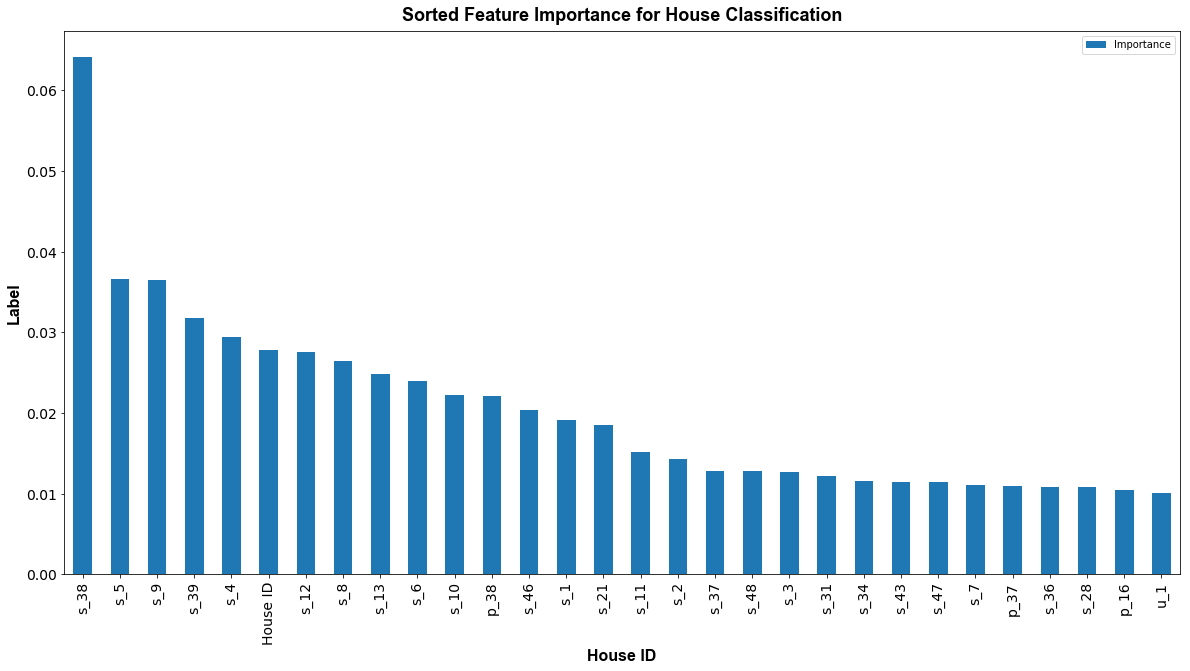

In [77]:
h_importance_df.sort_values('Importance', ascending=False).head(30).plot.bar(figsize=(20,10)) 
plt.xlabel('House ID', **axis_font)
plt.ylabel('Label', **axis_font)
plt.title("Sorted Feature Importance for House Classification", **title_font)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.tick_params(axis='both', which='minor', labelsize=13)
plt.show()

## Time Grid Search

In [78]:
print(X_train_time_augmented.shape)

(1028160, 24)


In [79]:
t_cv = ShuffleSplit(n_splits=10, test_size=0.20, random_state=42)
t_parameters = {'learning_rate': [0.09,0.10,0.11],
              'max_depth': [2,3,4],
             }  

X_valid_time_best, y_valid_time_best = ev.transform_house_subset_to_time(
    X_valid_house,
    y_valid_house_pred_best, # use predicted values, not true values
    ev_train_piv_lab_tmp_filled
)

X_valid_time_best_augmented = ev.augment_time_data(
    X_valid_time_best, 
    X_valid_house, 
    centers_df)

/Users/salvadornunez/Personal/udacity-mlnd-ev-capstone/ev_capstone_lib.py:175: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  t_X.drop(['Label'], axis=1, inplace=True)


In [80]:
# Time Grid Search 1

t_clf1 = GradientBoostingClassifier(random_state = 42)
t_grid1_obj = GridSearchCV(estimator=t_clf1, param_grid=t_parameters, scoring=scorer, cv=t_cv)

if os.path.isfile('pickle_files/t_grid1_list.pkl'):
    with open('pickle_files/t_grid1_list.pkl', 'rb') as input:
        t_grid1_list = pickle.load(input)
        t_grid1_fit = t_grid1_list[0]
        t_grid1_time = t_grid1_list[1]
        print("Training Time (sec) : {0:.3f}".format(t_grid1_time))
else:
    t_grid1_start = time.time()
    t_grid1_fit = t_grid1_obj.fit(X_train_time_augmented, y_train_time)
    t_grid1_end = time.time()
    t_grid1_time = t_grid1_end - t_grid1_start
    print("Training Time (sec) : {0:.3f}".format(t_grid1_time))
    
    t_grid1_list = [t_grid1_fit, t_grid1_time]
    save_object(t_grid1_list, 'pickle_files/t_grid1_list.pkl') 

best_t1_clf = t_grid1_fit.best_estimator_

print("\nBest Classifier Parameters: ")
print(best_t1_clf)

print("\nTraining Cross-Validation F1-Score: {0:.3f}".format(t_grid1_fit.best_score_))
print("\n")

y_valid_time_pred_best1 = best_t1_clf.predict(X_valid_time_best_augmented)

all_y_valid_time_pred_best1, all_y_valid_time_true, all_Xy_valid_time = ev.get_all_relevant_preds_and_trues(
    X_valid_time_best_augmented,
    y_valid_time_pred_best1,
    X_valid_house,
    ev_train_piv_lab_tmp_filled)

print("Final Validation F1-Score: {0:.3f}".format(f1_score(all_y_valid_time_true, all_y_valid_time_pred_best1)))

Training Time (sec) : 34417.224

Best Classifier Parameters: 
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.11, loss='deviance', max_depth=4,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=42,
              subsample=1.0, verbose=0, warm_start=False)

Training Cross-Validation F1-Score: 0.742


334080 base predictions extended to 1146240 total predictions, filled with zeros for non-EV houses.
Final Validation F1-Score: 0.586


In [81]:
# Time Grid Search 2

t_clf2 = GradientBoostingClassifier(random_state = 266)
t_grid2_obj = GridSearchCV(estimator=t_clf2, param_grid=t_parameters, scoring=scorer, cv=t_cv)

if os.path.isfile('pickle_files/t_grid2_list.pkl'):
    with open('pickle_files/t_grid2_list.pkl', 'rb') as input:
        t_grid2_list = pickle.load(input)
        t_grid2_fit = t_grid2_list[0]
        t_grid2_time = t_grid2_list[1]
        print("Training Time (sec) : {0:.3f}".format(t_grid2_time))
else:
    t_grid2_start = time.time()
    t_grid2_fit = t_grid2_obj.fit(X_train_time_augmented, y_train_time)
    t_grid2_end = time.time()
    t_grid2_time = t_grid2_end - t_grid2_start
    print("Training Time (sec) : {0:.3f}".format(t_grid2_time))
    
    t_grid2_list = [t_grid2_fit, t_grid2_time]
    save_object(t_grid2_list, 'pickle_files/t_grid2_list.pkl') 


best_t2_clf = t_grid2_fit.best_estimator_

print("\nBest Classifier Parameters: ")
print(best_t2_clf)

print("\nTraining Cross-Validation F1-Score: {0:.3f}".format(t_grid2_fit.best_score_))
print("\n")

y_valid_time_pred_best2 = best_t2_clf.predict(X_valid_time_best_augmented)

all_y_valid_time_pred_best2, all_y_valid_time_true, all_Xy_valid_time = ev.get_all_relevant_preds_and_trues(
    X_valid_time_best_augmented,
    y_valid_time_pred_best2,
    X_valid_house,
    ev_train_piv_lab_tmp_filled)

print("Final Validation F1-Score: {0:.3f}".format(f1_score(all_y_valid_time_true, all_y_valid_time_pred_best2)))

Training Time (sec) : 35166.015

Best Classifier Parameters: 
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.11, loss='deviance', max_depth=4,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=266,
              subsample=1.0, verbose=0, warm_start=False)

Training Cross-Validation F1-Score: 0.742


334080 base predictions extended to 1146240 total predictions, filled with zeros for non-EV houses.
Final Validation F1-Score: 0.586


In [82]:
# Time Grid Search 3

t_clf3 = GradientBoostingClassifier(random_state = 737)
t_grid3_obj = GridSearchCV(estimator=t_clf3, param_grid=t_parameters, scoring=scorer, cv=t_cv)

if os.path.isfile('pickle_files/t_grid3_list.pkl'):
    with open('pickle_files/t_grid3_list.pkl', 'rb') as input:
        t_grid3_list = pickle.load(input)
        t_grid3_fit = t_grid3_list[0]
        t_grid3_time = t_grid3_list[1]
        print("Training Time (sec) : {0:.3f}".format(t_grid3_time))
else:
    t_grid3_start = time.time()
    t_grid3_fit = t_grid3_obj.fit(X_train_time_augmented, y_train_time)
    t_grid3_end = time.time()
    t_grid3_time = t_grid3_end - t_grid3_start
    print("Training Time (sec) : {0:.3f}".format(t_grid3_time))
    
    t_grid3_list = [t_grid3_fit, t_grid3_time]
    save_object(t_grid3_list, 'pickle_files/t_grid3_list.pkl') 

best_t3_clf = t_grid3_fit.best_estimator_

print("\nBest Classifier Parameters: ")
print(best_t3_clf)

print("\nTraining Cross-Validation F1-Score: {0:.3f}".format(t_grid3_fit.best_score_))
print("\n")

y_valid_time_pred_best3 = best_t3_clf.predict(X_valid_time_best_augmented)

all_y_valid_time_pred_best3, all_y_valid_time_true, all_Xy_valid_time = ev.get_all_relevant_preds_and_trues(
    X_valid_time_best_augmented,
    y_valid_time_pred_best3,
    X_valid_house,
    ev_train_piv_lab_tmp_filled)

print("Final Validation F1-Score: {0:.3f}".format(f1_score(all_y_valid_time_true, all_y_valid_time_pred_best3)))


Training Time (sec) : 34344.347

Best Classifier Parameters: 
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.11, loss='deviance', max_depth=4,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=737,
              subsample=1.0, verbose=0, warm_start=False)

Training Cross-Validation F1-Score: 0.742


334080 base predictions extended to 1146240 total predictions, filled with zeros for non-EV houses.
Final Validation F1-Score: 0.586


In [83]:
# Time Grid Search 4

t_parameters4 = {'learning_rate': [0.10,0.11,0.12],
              'max_depth': [3,4,5],
             }  

t_clf4 = GradientBoostingClassifier(random_state = 42)
t_grid4_obj = GridSearchCV(estimator=t_clf4, param_grid=t_parameters4, scoring=scorer, cv=t_cv)

if os.path.isfile('pickle_files/t_grid4_list.pkl'):
    with open('pickle_files/t_grid4_list.pkl', 'rb') as input:
        t_grid4_list = pickle.load(input)
        t_grid4_fit = t_grid4_list[0]
        t_grid4_time = t_grid4_list[1]
        print("Training Time (sec) : {0:.3f}".format(t_grid4_time))
else:
    t_grid4_start = time.time()
    t_grid4_fit = t_grid4_obj.fit(X_train_time_augmented, y_train_time)
    t_grid4_end = time.time()
    t_grid4_time = t_grid4_end - t_grid4_start
    print("Training Time (sec) : {0:.3f}".format(t_grid4_time))
    
    t_grid4_list = [t_grid4_fit, t_grid4_time]
    save_object(t_grid4_list, 'pickle_files/t_grid4_list.pkl') 

best_t4_clf = t_grid4_fit.best_estimator_

print("\nBest Classifier Parameters: ")
print(best_t4_clf)

print("\nTraining Cross-Validation F1-Score: {0:.3f}".format(t_grid4_fit.best_score_))
print("\n")

y_valid_time_pred_best4 = best_t4_clf.predict(X_valid_time_best_augmented)

all_y_valid_time_pred_best4, all_y_valid_time_true, all_Xy_valid_time = ev.get_all_relevant_preds_and_trues(
    X_valid_time_best_augmented,
    y_valid_time_pred_best4,
    X_valid_house,
    ev_train_piv_lab_tmp_filled)

print("Final Validation F1-Score: {0:.3f}".format(f1_score(all_y_valid_time_true, all_y_valid_time_pred_best4)))

Training Time (sec) : 52331.622

Best Classifier Parameters: 
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.12, loss='deviance', max_depth=5,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=42,
              subsample=1.0, verbose=0, warm_start=False)

Training Cross-Validation F1-Score: 0.760


334080 base predictions extended to 1146240 total predictions, filled with zeros for non-EV houses.
Final Validation F1-Score: 0.589


In [84]:
# Time Grid Search 5

t_parameters5 = {'learning_rate': [0.11,0.12,0.13],
              'max_depth': [4,5,6],
             }  

t_clf5 = GradientBoostingClassifier(random_state = 42)
t_grid5_obj = GridSearchCV(estimator=t_clf5, param_grid=t_parameters5, scoring=scorer, cv=t_cv)

if os.path.isfile('pickle_files/t_grid5_list.pkl'):
    with open('pickle_files/t_grid5_list.pkl', 'rb') as input:
        t_grid5_list = pickle.load(input)
        t_grid5_fit = t_grid5_list[0]
        t_grid5_time = t_grid5_list[1]
        print("Training Time (sec) : {}".format(t_grid5_time))
else:
    t_grid5_start = time.time()
    t_grid5_fit = t_grid5_obj.fit(X_train_time_augmented, y_train_time)
    t_grid5_end = time.time()
    t_grid5_time = t_grid5_end - t_grid5_start
    print("Training Time (sec) : {}".format(t_grid5_time))
    
    t_grid5_list = [t_grid5_fit, t_grid5_time]
    save_object(t_grid5_list, 'pickle_files/t_grid5_list.pkl') 

best_t5_clf = t_grid5_fit.best_estimator_

print("\nBest Classifier Parameters: ")
print(best_t5_clf)

print("\nTraining Cross-Validation F1-Score: {0:.3f}".format(t_grid5_fit.best_score_))
print("\n")

y_valid_time_pred_best5 = best_t5_clf.predict(X_valid_time_best_augmented)

all_y_valid_time_pred_best5, all_y_valid_time_true, all_Xy_valid_time = ev.get_all_relevant_preds_and_trues(
    X_valid_time_best_augmented,
    y_valid_time_pred_best5,
    X_valid_house,
    ev_train_piv_lab_tmp_filled)

print("Final Validation F1-Score: {0:.3f}".format(f1_score(all_y_valid_time_true, all_y_valid_time_pred_best5)))

Training Time (sec) : 72994.42772603035

Best Classifier Parameters: 
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.13, loss='deviance', max_depth=6,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=42,
              subsample=1.0, verbose=0, warm_start=False)

Training Cross-Validation F1-Score: 0.775


334080 base predictions extended to 1146240 total predictions, filled with zeros for non-EV houses.
Final Validation F1-Score: 0.592


In [85]:
# Time Grid Search 6

t_parameters6 = {'learning_rate': [0.12,0.13,0.14],
              'max_depth': [5,6,7],
             }  

t_clf6 = GradientBoostingClassifier(random_state = 42)
t_grid6_obj = GridSearchCV(estimator=t_clf6, param_grid=t_parameters6, scoring=scorer, cv=t_cv)

if os.path.isfile('pickle_files/t_grid6_list.pkl'):
    with open('pickle_files/t_grid6_list.pkl', 'rb') as input:
        t_grid6_list = pickle.load(input)
        t_grid6_fit = t_grid6_list[0]
        t_grid6_time = t_grid6_list[1]
        print("Training Time (sec) : {0:.3f}".format(t_grid6_time))
else:
    t_grid6_start = time.time()
    t_grid6_fit = t_grid6_obj.fit(X_train_time_augmented, y_train_time)
    t_grid6_end = time.time()
    t_grid6_time = t_grid6_end - t_grid6_start
    print("Training Time (sec) : {0:.3f}".format(t_grid6_time))
    
    t_grid6_list = [t_grid6_fit, t_grid6_time]
    save_object(t_grid6_list, 'pickle_files/t_grid6_list.pkl') 

best_t6_clf = t_grid6_fit.best_estimator_

print("\nBest Classifier Parameters: ")
print(best_t6_clf)

print("\nTraining Cross-Validation F1-Score: {0:.3f}".format(t_grid6_fit.best_score_))
print("\n")

y_valid_time_pred_best6 = best_t6_clf.predict(X_valid_time_best_augmented)

all_y_valid_time_pred_best6, all_y_valid_time_true, all_Xy_valid_time = ev.get_all_relevant_preds_and_trues(
    X_valid_time_best_augmented,
    y_valid_time_pred_best6,
    X_valid_house,
    ev_train_piv_lab_tmp_filled)

print("Final Validation F1-Score: {0:.3f}".format(f1_score(all_y_valid_time_true, all_y_valid_time_pred_best6)))


Training Time (sec) : 109800.890

Best Classifier Parameters: 
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.14, loss='deviance', max_depth=7,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=42,
              subsample=1.0, verbose=0, warm_start=False)

Training Cross-Validation F1-Score: 0.787


334080 base predictions extended to 1146240 total predictions, filled with zeros for non-EV houses.
Final Validation F1-Score: 0.587


## Time Classifier Result

In [86]:
best_t_clf = best_t5_clf
all_y_valid_time_pred_best = all_y_valid_time_pred_best5

t_importance_df = pd.DataFrame(best_t_clf.feature_importances_,
                              index=X_train_time_augmented.columns,
                              columns=['Importance'])
t_importance_df

,Importance
House ID,0.128413
Day,0.005445
Hour,0.009746
Half Hour,0.029853
Interval,0.088461
kWh,0.112949
Day_kWh,0.038775
k_9,0.049896
c1,0.010126
c2,0.033648


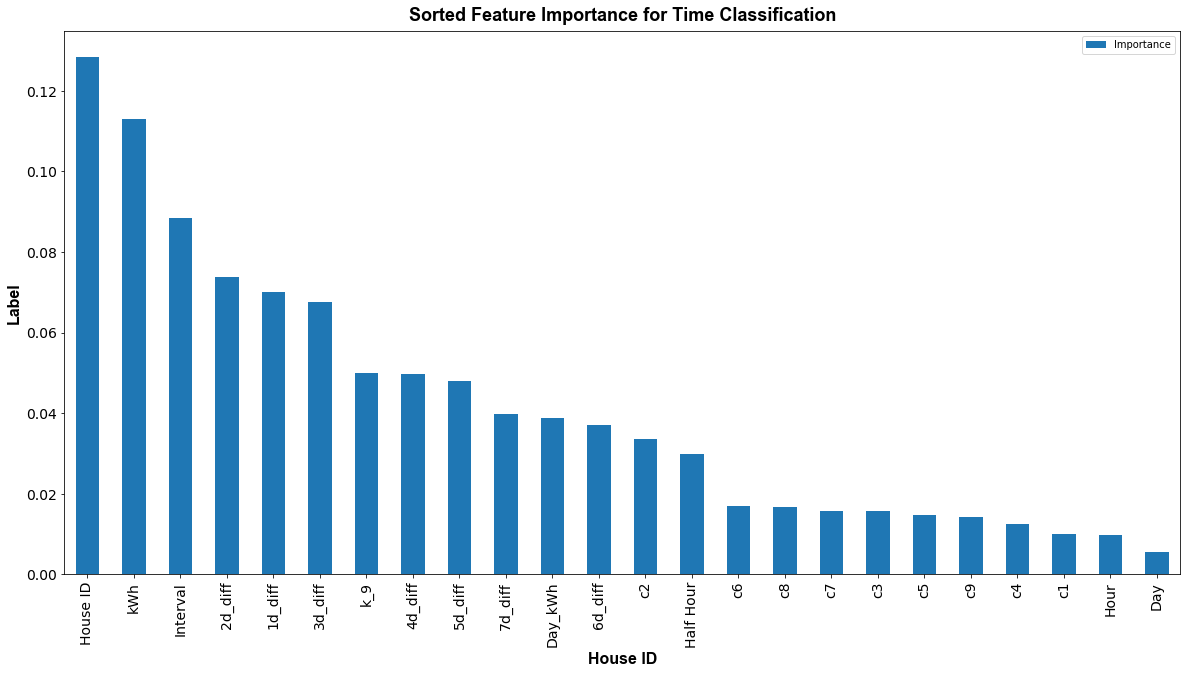

In [87]:
t_importance_df.sort_values('Importance', ascending=False).plot.bar(figsize=(20,10))
plt.xlabel('House ID', **axis_font)
plt.ylabel('Label', **axis_font)
plt.title("Sorted Feature Importance for Time Classification", **title_font)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.tick_params(axis='both', which='minor', labelsize=13)
plt.show()

# Predict Test Data

## Import

In [88]:
ev_test_raw = pd.read_csv('source_files/EV_test.csv')

In [89]:
print(ev_test_raw.shape)
display(ev_test_raw.head())

(699, 2881)


,House ID,Interval_1,Interval_2,Interval_3,Interval_4,Interval_5,Interval_6,Interval_7,Interval_8,Interval_9,...,Interval_2871,Interval_2872,Interval_2873,Interval_2874,Interval_2875,Interval_2876,Interval_2877,Interval_2878,Interval_2879,Interval_2880
0,11643173,1.013,0.215,0.217,0.217,0.217,0.220,0.220,0.215,0.215,...,1.059,0.308,1.248,0.236,0.206,0.210,0.218,0.219,0.909,0.202
1,11655020,1.325,1.413,0.813,0.588,0.213,0.175,0.163,0.200,0.175,...,0.750,0.625,0.450,1.325,0.350,0.313,0.188,0.200,0.188,0.175
2,11644367,1.543,1.636,1.683,1.556,1.935,2.393,2.601,2.709,2.590,...,2.208,2.423,2.458,2.487,2.354,2.444,2.430,2.275,1.914,1.497
3,11633356,0.153,0.123,0.146,0.101,0.140,0.108,0.121,0.127,0.110,...,0.216,0.237,0.213,0.258,0.275,0.219,0.218,0.079,0.049,0.055
4,11649905,0.187,0.004,0.004,0.004,0.004,0.004,0.005,0.004,0.004,...,0.004,0.005,0.526,0.005,0.004,0.004,0.004,0.004,0.004,0.004


## Data Preprocessing

In [90]:
print(ev_test_raw.isnull().values.any())
display(ev_test_raw[ev_test_raw.isnull().any(axis=1)])

True


,House ID,Interval_1,Interval_2,Interval_3,Interval_4,Interval_5,Interval_6,Interval_7,Interval_8,Interval_9,...,Interval_2871,Interval_2872,Interval_2873,Interval_2874,Interval_2875,Interval_2876,Interval_2877,Interval_2878,Interval_2879,Interval_2880
568,11646117,0.797,0.794,0.789,0.786,0.789,0.79,0.787,0.789,0.788,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
686,11643165,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.028,1.416,0.973,0.956,0.952,1.101,1.044,1.066,1.314,1.051


In [91]:
ev_test_kwh_pivot = ev.pivot_raw_df(ev_test_raw, 'kWh')
display(ev_test_kwh_pivot.head())

,House ID,Interval,kWh
0,11628297,1,0.815
1,11628297,2,0.743
2,11628297,3,0.832
3,11628297,4,0.880
4,11628297,5,0.909


In [92]:
ev_test_kwh_tmp = ev.add_temp_dim(ev_test_kwh_pivot)
display(ev_test_kwh_tmp.head())

,House ID,Day,Hour,Half Hour,Interval,kWh
0,11628297,1,1,1,1,0.815
1,11628297,1,1,2,2,0.743
2,11628297,1,2,3,3,0.832
3,11628297,1,2,4,4,0.880
4,11628297,1,3,5,5,0.909


In [93]:
ev_test_kwh_tmp_filled = ev.fill_with_mean(ev_test_kwh_tmp)
display(ev_test_kwh_tmp_filled.head())

/Users/salvadornunez/Personal/udacity-mlnd-ev-capstone/ev_capstone_lib.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_filled['kWh'][house_rf&interval_rf] = house_half_hour_average


,House ID,Day,Hour,Half Hour,Interval,kWh
0,11628297,1,1,1,1,0.815
1,11628297,1,1,2,2,0.743
2,11628297,1,2,3,3,0.832
3,11628297,1,2,4,4,0.880
4,11628297,1,3,5,5,0.909


## House Clasification

In [94]:
X_test_house = ev.house_agg_and_split(ev_test_kwh_tmp_filled, has_label=False)
display(X_test_house.head())

,House ID,u_1,u_2,u_3,u_4,u_5,u_6,u_7,u_8,u_9,...,p_39,p_40,p_41,p_42,p_43,p_44,p_45,p_46,p_47,p_48
0,11628297,0.927867,0.949667,0.945517,0.841783,0.850367,0.754783,0.804183,0.738167,0.774850,...,0.019316,0.017176,0.016737,0.017960,0.019136,0.020417,0.022542,0.021078,0.023207,0.023409
1,11628334,2.895467,2.833850,2.919050,2.796850,2.793900,2.743067,2.732717,2.699267,2.644783,...,0.016102,0.015117,0.014748,0.014691,0.014106,0.013406,0.013151,0.012909,0.012194,0.011661
2,11628336,0.473767,0.529617,0.536767,0.536183,0.470550,0.476933,0.491483,0.531817,0.551617,...,0.027206,0.027963,0.024844,0.022905,0.021417,0.019448,0.020517,0.020493,0.020261,0.017703
3,11628349,0.386800,0.395833,0.411133,0.437267,0.565158,0.543272,0.529695,0.496292,0.593909,...,0.027357,0.031569,0.025880,0.019876,0.024999,0.025998,0.018503,0.013603,0.011801,0.010329
4,11628351,0.504433,0.442333,0.256083,0.247050,0.248383,0.240750,0.246633,0.250550,0.478350,...,0.036389,0.032397,0.026712,0.024508,0.028705,0.027695,0.029181,0.027240,0.019270,0.016636


In [95]:
X_test_house[k_col_name] = neigh.predict(X_test_house[KNN_cols]) # use trained KNN classifier
display(X_test_house.head())

,House ID,u_1,u_2,u_3,u_4,u_5,u_6,u_7,u_8,u_9,...,p_40,p_41,p_42,p_43,p_44,p_45,p_46,p_47,p_48,k_9
0,11628297,0.927867,0.949667,0.945517,0.841783,0.850367,0.754783,0.804183,0.738167,0.774850,...,0.017176,0.016737,0.017960,0.019136,0.020417,0.022542,0.021078,0.023207,0.023409,2
1,11628334,2.895467,2.833850,2.919050,2.796850,2.793900,2.743067,2.732717,2.699267,2.644783,...,0.015117,0.014748,0.014691,0.014106,0.013406,0.013151,0.012909,0.012194,0.011661,4
2,11628336,0.473767,0.529617,0.536767,0.536183,0.470550,0.476933,0.491483,0.531817,0.551617,...,0.027963,0.024844,0.022905,0.021417,0.019448,0.020517,0.020493,0.020261,0.017703,2
3,11628349,0.386800,0.395833,0.411133,0.437267,0.565158,0.543272,0.529695,0.496292,0.593909,...,0.031569,0.025880,0.019876,0.024999,0.025998,0.018503,0.013603,0.011801,0.010329,5
4,11628351,0.504433,0.442333,0.256083,0.247050,0.248383,0.240750,0.246633,0.250550,0.478350,...,0.032397,0.026712,0.024508,0.028705,0.027695,0.029181,0.027240,0.019270,0.016636,5


In [96]:
y_test_house_pred = best_h_clf.predict(X_test_house) # use best trained house classifier via Grid Search

## Time Classification

In [97]:
X_test_time = ev.transform_house_subset_to_time(
    X_test_house,
    y_test_house_pred,
    ev_test_kwh_tmp_filled,
    has_label=False
)
display(X_test_time.head())

,House ID,Day,Hour,Half Hour,Interval,kWh
2880,11628334,1,1,1,1,2.250
2881,11628334,1,1,2,2,2.134
2882,11628334,1,2,3,3,2.045
2883,11628334,1,2,4,4,2.569
2884,11628334,1,3,5,5,2.540


In [98]:
X_test_time_augmented = ev.augment_time_data(
    X_test_time, 
    X_test_house, 
    centers_df) 
display(X_test_time_augmented.head())

,House ID,Day,Hour,Half Hour,Interval,kWh,Day_kWh,k_9,c1,c2,...,c7,c8,c9,1d_diff,2d_diff,3d_diff,4d_diff,5d_diff,6d_diff,7d_diff
0,11628334,1,1,1,1,2.250,129.233,4,1.109382,1.145898,...,4.516245,0.497525,1.267279,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,11628334,1,1,2,2,2.134,129.233,4,1.068470,1.152646,...,4.448900,0.505032,1.187596,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,11628334,1,2,3,3,2.045,129.233,4,1.045225,1.151754,...,4.209808,0.504814,1.157941,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,11628334,1,2,4,4,2.569,129.233,4,1.035875,1.138831,...,4.156392,0.506001,1.131162,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,11628334,1,3,5,5,2.540,129.233,4,1.019826,1.180720,...,4.162798,0.503516,1.093789,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [99]:
X_test_time_augmented.columns.values

array(['House ID', 'Day', 'Hour', 'Half Hour', 'Interval', 'kWh',
       'Day_kWh', 'k_9', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8',
       'c9', '1d_diff', '2d_diff', '3d_diff', '4d_diff', '5d_diff',
       '6d_diff', '7d_diff'], dtype=object)

In [100]:
y_test_time_pred = best_t1_clf.predict(X_test_time_augmented) # use best trained time classifier via Grid Search

## Format Final Result

In [101]:
all_y_test_time_pred, all_y_test_time_true, all_Xy_test_time = ev.get_all_relevant_preds_and_trues(
    X_test_time_augmented,
    y_test_time_pred,
    X_test_house,
    ev_test_kwh_tmp_filled)
display(all_Xy_test_time.head()) 

509760 base predictions extended to 2013120 total predictions, filled with zeros for non-EV houses.


,House ID,Interval,Predicted Label,Filled Label
0,11628297,1,NaN,0
1,11628297,2,NaN,0
2,11628297,3,NaN,0
3,11628297,4,NaN,0
4,11628297,5,NaN,0


In [102]:
ev_test_label_predictions = ev.format_ev_predictions(
    all_y_test_time_pred, 
    all_Xy_test_time
)
display(ev_test_label_predictions.head())

,House ID,Interval_1,Interval_2,Interval_3,Interval_4,Interval_5,Interval_6,Interval_7,Interval_8,Interval_9,...,Interval_2871,Interval_2872,Interval_2873,Interval_2874,Interval_2875,Interval_2876,Interval_2877,Interval_2878,Interval_2879,Interval_2880
0,11628297,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,11628334,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,11628336,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,11628349,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,11628351,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [103]:
ev_test_label_predictions.to_csv('submissions/EV_test_labels.csv', index=False)